<a href="https://colab.research.google.com/github/aicrashcoursewinter24/ai_crashcourselabsLukeA/blob/FineTuneLAB/phi2_finetune_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brev-xmas-3.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning Microsoft's Phi-2 using QLoRA 🤙

Welcome!

In this notebook and tutorial, we will fine-tune [Microsoft's Phi-2](https://huggingface.co/microsoft/phi-2) relatively small 2.7B model - which has "showcased a nearly state-of-the-art performance among models with less than 13 billion parameters".

No A100 needed!

**Watch an accompanying video walk-through (but for Mistral 7B and using your own data, but the notebook is very similar) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)!** If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb). If you'd like to see a notebook to fine-tune Phi-2 on **your own data**, click [here](https://github.com/brevdev/notebooks/blob/main/phi2-finetune-own-data.ipynb).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works). We will load the model in 8-bit and then apply LoRA adapters.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

### 1. Instantiate GPU

I used a GPU and dev environment from [brev.dev](https://brev.dev). Click the badge below to get your preconfigured instance:

[![](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=phi2-finetune&file=https://github.com/brevdev/notebooks/raw/main/phi2-finetune.ipynb&python=3.10&cuda=12.0.1)

A single A10G (as linked) with 24GB GPU Memory was enough for me. You may need more GPUs and/or Memory if your sequence max_length is larger than 320 (more on that below).

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.0.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [ ]:
# You only need to run this once per machine, even if you stop/restart it
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### 2. Accelerator / W&B

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "viggo-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 3. Load Dataset

Let's load a meaning representation dataset, and fine-tune Mixtral on that. This is a great fine-tuning dataset as it teaches the model a unique form of desired output on which the base model performs poorly out-of-the box, so it's helpful to easily and inexpensively gauge whether the fine-tuned model has learned well. (Sources: [here](https://ragntune.com/blog/gpt3.5-vs-llama2-finetuning) and [here](https://www.anyscale.com/blog/fine-tuning-is-for-form-not-facts)) (In contrast, if you fine-tune on a fact-based dataset, the model may already do quite well on that, and gauging learning is less obvious / may be more computationally expensive.)

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('gem/viggo', split='train')
eval_dataset = load_dataset('gem/viggo', split='validation')
test_dataset = load_dataset('gem/viggo', split='test')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for gem/viggo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/gem/viggo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating challenge_train_1_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_2_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_5_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_10_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_20_percent split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for gem/viggo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/gem/viggo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 714
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 1083
})


### 4. Load Base Model

Let's load Phi-2 in 8-bit quantization.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             load_in_8bit=True,
                                             torch_dtype=torch.float16,
                                             trust_remote_code=True)

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

### 5. Tokenization

Set up the tokenizer.

To set `max_length`, which has a direct impact on your compute requirements, it's helpful to get a distribution of your data lengths. Hugging Face shares that data clearly, like so:

![image.png](attachment:77593312-b2b3-4238-891b-417930e2e9b9.png)

However, since we're combining multiple features of this dataset in `generate_and_tokenize_prompt`, let's get our own distribution of the final form of the data. Let's first tokenize without the truncation/padding, so we can get that length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Setup the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning):

In [ ]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

And convert each sample into a prompt that I found from [this notebook](https://github.com/samlhuillier/viggo-finetune/blob/main/llama/fine-tune-code-llama.ipynb).

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

You can untokenize to make sure it was formatted properly.

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

<|endoftext|>Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform','request', 'give_opinion', 'confirm','verify_attribute','suggest','request_explanation','recommend','request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date','release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release','specifier']

### Target sentence:
Dirt: Showdown is a sport racing game that was released in 2012. The game is available on PlayStation, Xbox, and PC, and it has an ESRB Rating of E 10+ (for Everyone 10 and Older). However, it is not yet available as a Steam, Linux, or Mac release.

### Meaning representation:
inform(name[Dirt: Showdown], release_ye

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

5817


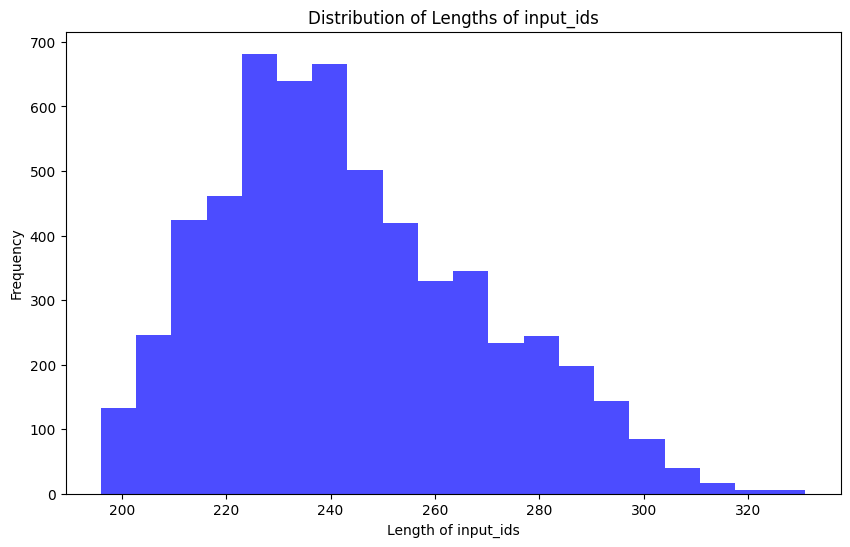

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [ ]:
max_length = 275 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

Generally, each `input_ids` should be padded on the left with the `eos_token` (50256) and there should be an `eos_token` 50256 added to the end, and the prompt should start with a `bos_token` (?). However, I'm getting an error with Phi-2's tokenizer. GPU credits for whoever can resolve this!

Hopefully should work just fine as-is.


In [ ]:
print(tokenized_train_dataset[4]['input_ids'])

[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 15056, 257, 2496, 6827, 5678, 262, 10238, 3616, 10552, 286, 262, 5128, 6827, 355, 257, 2060, 2163, 351, 12608, 290, 11688, 3815, 13, 198, 1212, 2163, 815, 6901, 262, 2496, 4731, 14351, 290, 262, 2163, 1276, 307, 530, 286, 262, 1708, 37250, 259, 687, 3256, 705, 25927, 3256, 705, 26535, 62, 404, 23971, 3256, 705, 10414, 2533, 3256, 705, 332, 1958, 62, 42348, 3256, 705, 47811, 3256, 705, 25927, 62, 1069, 11578, 341, 3256, 705, 47335, 437, 3256, 705, 25927, 62, 42348, 6, 4083, 198, 464, 12608, 1276, 307, 530, 286, 262, 1708, 25, 37250,

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[4]['input_ids'])
print(untokenized_text)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribu

Now all the samples should be the same length, `max_length` (320 for me).

5817


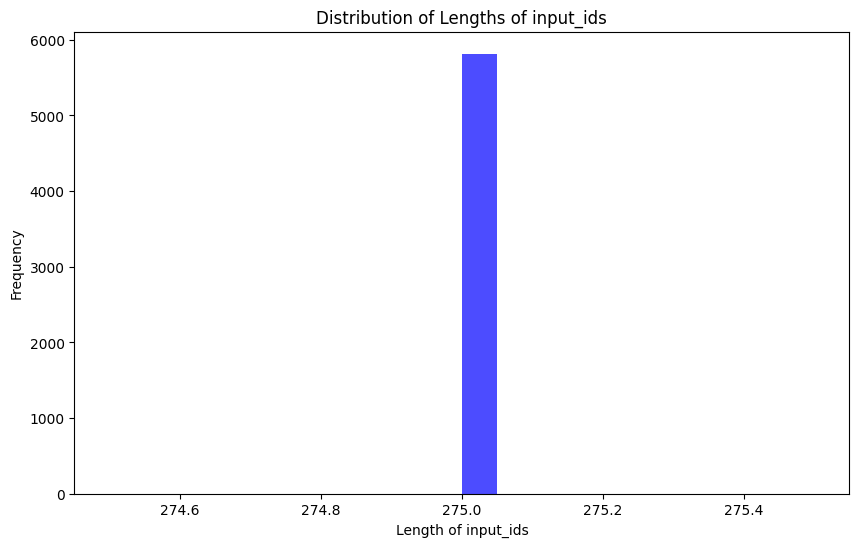

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

#### How does the base model do?

Let's grab a test input (`meaning_representation`) and desired output (`target`) pair to see how the base model does on it.

In [ ]:
print("Target Sentence: " + test_dataset[1]['target'])
print("Meaning Representation: " + test_dataset[1]['meaning_representation'] + "\n")

Target Sentence: Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?
Meaning Representation: verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])



In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

In [ ]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [ ]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform','request', 'give_opinion', 'confirm','verify_attribute','suggest','request_explanation','recommend','request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date','release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release','specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
This function should describe the target sentence accurately and the function must be one of the following ['inform','request', 'give_opi

We can see it doesn't do very well out of the box.

### 6. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. Let's set up our LoRA layers.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to some linear layers of the model. Those layers are `Wqkv`, `fc1`, `fc2`.

In [ ]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=8` and `lora_alpha=16` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 6553600 || all params: 2786237440 || trainable%: 0.23521326308787235


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default): D

### 7. Run Training!

I used only 500 steps for the sake of getting this notebook out (it took about an hour), but I found the model should have trained for longer as it had not converged by then, so I upped the steps to 1000 below. It may even need longer.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`phi2-finetune-viggo`) as your final model in step 8 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "viggo-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Currently logged in as: luke-amm (collegeofidahowinter24). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,1.956000,1.503074
100,0.733600,0.504338
150,0.425100,0.356516
200,0.358300,0.315052
250,0.315400,0.295513
300,0.297000,0.282537
350,0.287700,0.272733
400,0.278200,0.264925
450,0.271000,0.258940
500,0.270800,0.253038


TrainOutput(global_step=1000, training_loss=0.41606353378295896, metrics={'train_runtime': 5029.5773, 'train_samples_per_second': 0.795, 'train_steps_per_second': 0.199, 'total_flos': 1.7524091904e+16, 'train_loss': 0.41606353378295896, 'epoch': 0.78})

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 8. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Phi-2 model from the Huggingface Hub:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
torch.cuda.empty_cache()
base_model_id = "microsoft/phi-2"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    load_in_8bit=True,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "phi2-viggo-finetune/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform','request', 'give_opinion', 'confirm','verify_attribute','suggest','request_explanation','recommend','request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date','release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release','specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no])

### Expected attributes:
name[Little Big Adventure], 

### Sweet... it worked! The fine-tuned model now understands the meaning representation!

It's not excellent, but I only fine-tuned it on 500 steps. The longer you fine-tune, the better you can expect it to perform (just watch for overfitting).  

I hope you enjoyed this tutorial on fine-tuning Microsoft's Phi-2. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or on the [Discord channel](https://discord.gg/y9428NwTh3).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙